In [1]:
#@title Check if MuJoCo installation was successful

import distutils.util
import os
import subprocess
if subprocess.run('nvidia-smi').returncode:
  raise RuntimeError(
      'Cannot communicate with GPU. '
      'Make sure you are using a GPU Colab runtime. '
      'Go to the Runtime menu and select Choose runtime type.')

# Add an ICD config so that glvnd can pick up the Nvidia EGL driver.
# This is usually installed as part of an Nvidia driver package, but the Colab
# kernel doesn't install its driver via APT, and as a result the ICD is missing.
# (https://github.com/NVIDIA/libglvnd/blob/master/src/EGL/icd_enumeration.md)
NVIDIA_ICD_CONFIG_PATH = '/usr/share/glvnd/egl_vendor.d/10_nvidia.json'
if not os.path.exists(NVIDIA_ICD_CONFIG_PATH):
  with open(NVIDIA_ICD_CONFIG_PATH, 'w') as f:
    f.write("""{
    "file_format_version" : "1.0.0",
    "ICD" : {
        "library_path" : "libEGL_nvidia.so.0"
    }
}
""")

# Configure MuJoCo to use the EGL rendering backend (requires GPU)
print('Setting environment variable to use GPU rendering:')
%env MUJOCO_GL=egl

try:
  print('Checking that the installation succeeded:')
  import mujoco
  mujoco.MjModel.from_xml_string('<mujoco/>')
except Exception as e:
  raise e from RuntimeError(
      'Something went wrong during installation. Check the shell output above '
      'for more information.\n'
      'If using a hosted Colab runtime, make sure you enable GPU acceleration '
      'by going to the Runtime menu and selecting "Choose runtime type".')

print('Installation successful.')

# Tell XLA to use Triton GEMM, this improves steps/sec by ~30% on some GPUs
xla_flags = os.environ.get('XLA_FLAGS', '')
xla_flags += ' --xla_gpu_triton_gemm_any=True'
os.environ['XLA_FLAGS'] = xla_flags

Mon Aug 25 08:43:48 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 560.35.03              Driver Version: 560.35.03      CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA A100 80GB PCIe          On  |   00000000:21:00.0 Off |                    0 |
| N/A   31C    P0             44W /  300W |       1MiB /  81920MiB |      0%      Default |
|                                         |                        |             Disabled |
+-----------------------------------------+-----

In [3]:
#@title Import packages for plotting and creating graphics
import time
import itertools
import numpy as np
from typing import Callable, NamedTuple, Optional, Union, List

# Graphics and plotting.
import mediapy as media
import matplotlib.pyplot as plt

# More legible printing from numpy.
np.set_printoptions(precision=3, suppress=True, linewidth=100)

In [4]:
#@title Import MuJoCo, MJX, and Brax
from datetime import datetime
from etils import epath
import functools
from IPython.display import HTML
from typing import Any, Dict, Sequence, Tuple, Union
import os
from ml_collections import config_dict


import jax
from jax import numpy as jp
import numpy as np
from flax.training import orbax_utils
from flax import struct
from matplotlib import pyplot as plt
import mediapy as media
from orbax import checkpoint as ocp

import mujoco
from mujoco import mjx

from brax import base
from brax import envs
from brax import math
from brax.base import Base, Motion, Transform
from brax.base import State as PipelineState
from brax.envs.base import Env, PipelineEnv, State
from brax.mjx.base import State as MjxState
from brax.training.agents.ppo import train as ppo
from brax.training.agents.ppo import networks as ppo_networks
from brax.io import html, mjcf, model

In [5]:
xml = """
<mujoco>
  <compiler inertiafromgeom="false" coordinate="local"/>

  <worldbody>
    <light name="top" pos="0 0 1"/>
    
    <body name="cart_x" pos="0 0 0">
      <inertial pos="0 0 0" mass="1e-6" diaginertia="1e-6 1e-6 1e-6" />
      <joint name="slider_x" type="slide" axis="1 0 0" limited="false"/>
      
      <body name="cart_y" pos="0 0 0">
        <inertial pos="0 0 0" mass="1" diaginertia="0.01 0.01 0.01" />
        <joint name="slider_y" type="slide" axis="0 1 0" limited="false"/>
        
        <geom name="sphere_geom" type="sphere" size=".2" rgba="1 0 0 1"/>
      </body>
    </body>
  </worldbody>

  <actuator>
    <motor name="force_x" joint="slider_x" gear="1" ctrllimited="false"/>
    <motor name="force_y" joint="slider_y" gear="1" ctrllimited="false"/>
  </actuator>
</mujoco>
"""


# Make model, data, and renderer
mj_model = mujoco.MjModel.from_xml_string(xml)
mj_data = mujoco.MjData(mj_model)
renderer = mujoco.Renderer(mj_model)

In [6]:
mjx_model = mjx.put_model(mj_model)
mjx_data = mjx.put_data(mj_model, mj_data)

In [7]:
print(mj_data.qpos, type(mj_data.qpos))
print(mjx_data.qpos, type(mjx_data.qpos), mjx_data.qpos.devices())

[0. 0.] <class 'numpy.ndarray'>
[0. 0.] <class 'jaxlib._jax.ArrayImpl'> {CudaDevice(id=0)}


In [8]:
!ffmpeg -version

ffmpeg version 7.1.1 Copyright (c) 2000-2025 the FFmpeg developers
built with gcc 14.3.0 (Spack GCC)
configuration: --prefix=/apps/spack/2506/apps/linux-rocky8-x86_64_v3/gcc-14.3.0/ffmpeg-7.1.1-mnarvdk --enable-pic --cc=/apps/spack/2506/spack-0.23/lib/spack/env/gcc/gcc --cxx=/apps/spack/2506/spack-0.23/lib/spack/env/gcc/g++ --disable-libxcb --disable-libxcb-shape --disable-libxcb-shm --disable-libxcb-xfixes --disable-xlib --disable-libfontconfig --disable-libfreetype --disable-libfribidi --enable-bzlib --disable-doc --enable-gpl --enable-libmp3lame --enable-libopenjpeg --enable-libopus --enable-libspeex --enable-libvorbis --enable-libvpx --enable-libx264 --disable-nonfree --enable-openssl --enable-shared --enable-version3 --disable-libzmq --disable-libssh --enable-libwebp --enable-lzma --enable-libsnappy --disable-sdl2 --enable-libaom --enable-libxml2
libavutil      59. 39.100 / 59. 39.100
libavcodec     61. 19.101 / 61. 19.101
libavformat    61.  7.100 / 61.  7.100
libavdevice    61. 

/home1/lutkus/.conda/envs/mjx_latent/lib/python3.13/pty.py:95: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


In [9]:
# enable joint visualization option:
scene_option = mujoco.MjvOption()
scene_option.flags[mujoco.mjtVisFlag.mjVIS_JOINT] = True

duration = 3.8  # (seconds)
framerate = 60  # (Hz)

frames = []
mujoco.mj_resetData(mj_model, mj_data)
mj_data.ctrl[0] = 0
mj_data.ctrl[1] = -1
print(mj_data.ctrl)
while mj_data.time < duration:
  mujoco.mj_step(mj_model, mj_data)
  if len(frames) < mj_data.time * framerate:
    renderer.update_scene(mj_data, scene_option=scene_option)
    pixels = renderer.render()
    frames.append(pixels)

# Simulate and display video.
media.show_video(frames, fps=framerate)

[ 0. -1.]


In [10]:
jit_step = jax.jit(mjx.step)

frames = []
mujoco.mj_resetData(mj_model, mj_data)
mj_data.ctrl[0] = 0
mj_data.ctrl[1] = -1
mjx_data = mjx.put_data(mj_model, mj_data)
while mjx_data.time < duration:
  mjx_data = jit_step(mjx_model, mjx_data)
  if len(frames) < mjx_data.time * framerate:
    mj_data = mjx.get_data(mj_model, mjx_data)
    renderer.update_scene(mj_data, scene_option=scene_option)
    pixels = renderer.render()
    frames.append(pixels)

media.show_video(frames, fps=framerate)

In [12]:
rng = jax.random.PRNGKey(0)
rng = jax.random.split(rng, 4096)
batch = jax.vmap(lambda rng: mjx_data.replace(qpos=jax.random.uniform(rng, (2,))))(rng)

jit_step = jax.jit(jax.vmap(mjx.step, in_axes=(None, 0)))
traj = [batch]

for t in range(10):
    traj.append(jit_step(mjx_model, traj[-1]))

import jax.numpy as jnp
X = jnp.dstack([step.qpos for step in traj])
print(X.shape)

print(traj[-1].qpos)
print(traj[-1].qpos.shape)

(4096, 2, 11)
[[ 0.842  0.106]
 [ 0.007 -0.055]
 [ 0.902  0.836]
 ...
 [ 0.005  0.059]
 [ 0.897  0.194]
 [ 0.136  0.423]]
(4096, 2)


In [ ]:
batched_mj_data = mjx.get_data(mj_model, batch)
print([d.qpos for d in batched_mj_data])

In [52]:
#@title Humanoid Env

#HUMANOID_ROOT_PATH = epath.Path(epath.resource_path('mujoco')) / 'mjx/test_data/humanoid'

class DoubleIntegrator(PipelineEnv):

  def __init__(
      self,
      forward_reward_weight=1.25,
      ctrl_cost_weight=0.1,
      healthy_reward=5.0,
      terminate_when_unhealthy=True,
      #healthy_z_range=(1.0, 2.0),
      healthy_x_range=(-20., 20.),
      healthy_y_range=(-20., 20.), 
      #reset_noise_scale=1e-2,
      reset_noise_scale=0.5e1,
      exclude_current_positions_from_observation=True,
      **kwargs,
  ):
#
    #mj_model = mujoco.MjModel.from_xml_path(
    #    (HUMANOID_ROOT_PATH / 'humanoid.xml').as_posix())
    mj_model = mujoco.MjModel.from_xml_string(xml)
    mj_model.opt.solver = mujoco.mjtSolver.mjSOL_CG
    mj_model.opt.iterations = 6
    mj_model.opt.ls_iterations = 6

    sys = mjcf.load_model(mj_model)

    physics_steps_per_control_step = 5
    kwargs['n_frames'] = kwargs.get(
        'n_frames', physics_steps_per_control_step)
    kwargs['backend'] = 'mjx'

    super().__init__(sys, **kwargs)

    self._forward_reward_weight = forward_reward_weight
    self._ctrl_cost_weight = ctrl_cost_weight
    self._healthy_reward = healthy_reward
    self._terminate_when_unhealthy = terminate_when_unhealthy
    #self._healthy_z_range = healthy_z_range
    self._healthy_x_range = healthy_x_range 
    self._healthy_y_range = healthy_y_range 
    self._reset_noise_scale = reset_noise_scale
    self._exclude_current_positions_from_observation = (
        exclude_current_positions_from_observation
    )

  def reset(self, rng: jp.ndarray) -> State:
    """Resets the environment to an initial state."""
    rng, rng1, rng2 = jax.random.split(rng, 3)

    low, hi = -self._reset_noise_scale, self._reset_noise_scale
    qpos = self.sys.qpos0 + jax.random.uniform(
        rng1, (self.sys.nq,), minval=low, maxval=hi
    )
    qvel = jax.random.uniform(
        rng2, (self.sys.nv,), minval=low, maxval=hi
    )

    data = self.pipeline_init(qpos, qvel)

    obs = self._get_obs(data, jp.zeros(self.sys.nu))
    reward, done, zero = jp.zeros(3)
    metrics = {
        'forward_reward': zero,
        'reward_linvel': zero,
        'reward_quadctrl': zero,
        'reward_alive': zero,
        'x_position': zero,
        'y_position': zero,
        'distance_from_origin': zero,
        'x_velocity': zero,
        'y_velocity': zero,
    }
    return State(data, obs, reward, done, metrics)

  def step(self, state: State, action: jp.ndarray) -> State:
    """Runs one timestep of the environment's dynamics."""
    data0 = state.pipeline_state
    data = self.pipeline_step(data0, action)

    com_before = data0.subtree_com[1]
    com_after = data.subtree_com[1]
    velocity = (com_after - com_before) / self.dt
    forward_reward = jp.clip(1/jp.linalg.norm(com_after), max=5000)
    #forward_reward = self._forward_reward_weight * velocity[0]

    #min_z, max_z = self._healthy_z_range
    #is_healthy = jp.where(data.q[2] < min_z, 0.0, 1.0)
    #is_healthy = jp.where(data.q[2] > max_z, 0.0, is_healthy)
    min_x, max_x = self._healthy_x_range
    is_healthy = jp.where(data.q[0] < min_x, 0.0, 1.0)
    is_healthy = jp.where(data.q[0] > max_x, 0.0, is_healthy)     
    min_y, max_y = self._healthy_y_range
    is_healthy = jp.where(data.q[0] < min_y, 0.0, 1.0)
    is_healthy = jp.where(data.q[0] > max_y, 0.0, is_healthy)     
      
    if self._terminate_when_unhealthy:
      healthy_reward = self._healthy_reward
    else:
      healthy_reward = self._healthy_reward * is_healthy

    ctrl_cost = self._ctrl_cost_weight * jp.sum(jp.square(action))

    obs = self._get_obs(data, action)
    reward = forward_reward + healthy_reward - ctrl_cost
    #reward = healthy_reward - ctrl_cost
    done = 1.0 - is_healthy if self._terminate_when_unhealthy else 0.0
    state.metrics.update(
        forward_reward=forward_reward,
        #reward_linvel=forward_reward,
        reward_quadctrl=-ctrl_cost,
        reward_alive=healthy_reward,
        x_position=com_after[0],
        y_position=com_after[1],
        distance_from_origin=jp.linalg.norm(com_after),
        x_velocity=velocity[0],
        y_velocity=velocity[1],
    )

    return state.replace(
        pipeline_state=data, obs=obs, reward=reward, done=done
    )

  def _get_obs(
      self, data: mjx.Data, action: jp.ndarray
  ) -> jp.ndarray:
    """Observes humanoid body position, velocities, and angles."""
    position = data.qpos
    if self._exclude_current_positions_from_observation:
      position = position[2:]

    # external_contact_forces are excluded
    return jp.concatenate([
        position,
        data.qvel,
        data.cinert[1:].ravel(),
        data.cvel[1:].ravel(),
        data.qfrc_actuator,
    ])


envs.register_environment('double_integrator', DoubleIntegrator)

In [53]:
# instantiate the environment
env_name = 'double_integrator'
env = envs.get_environment(env_name)

# define the jit reset/step functions
jit_reset = jax.jit(env.reset)
jit_step = jax.jit(env.step)

In [54]:
# initialize the state
state = jit_reset(jax.random.PRNGKey(0))
rollout = [state.pipeline_state]

# grab a trajectory
for i in range(100):
  ctrl = -0.1 * jp.ones(env.sys.nu)
  state = jit_step(state, ctrl)
  rollout.append(state.pipeline_state)

#media.show_video(env.render(rollout, camera='side'), fps=1.0 / env.dt)
media.show_video(env.render(rollout), fps=1.0 / env.dt)

/tmp/SLURM_1876284/ipykernel_1441385/2175541655.py:139: DeprecationWarning: Accessing `cinert` directly from `Data` is deprecated. Access it via `data._impl.cinert` instead.
  data.cinert[1:].ravel(),


/tmp/SLURM_1876284/ipykernel_1441385/2175541655.py:139: DeprecationWarning: Accessing `cinert` directly from `Data` is deprecated. Access it via `data._impl.cinert` instead.
  data.cinert[1:].ravel(),


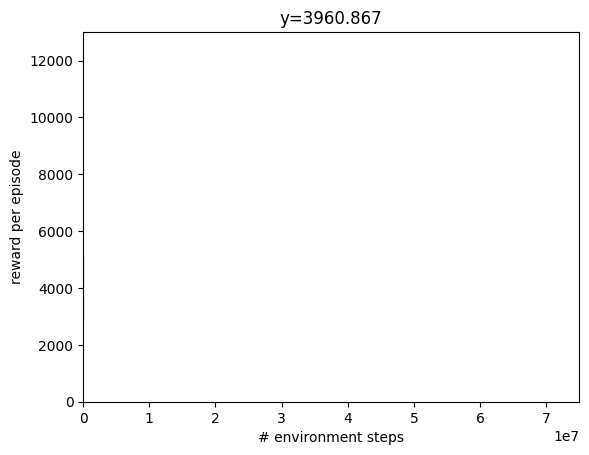

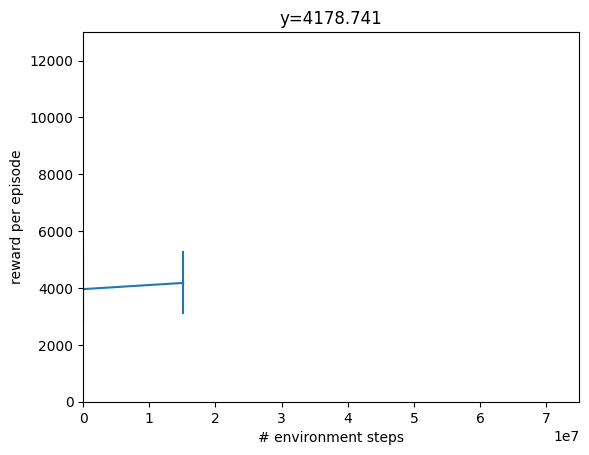

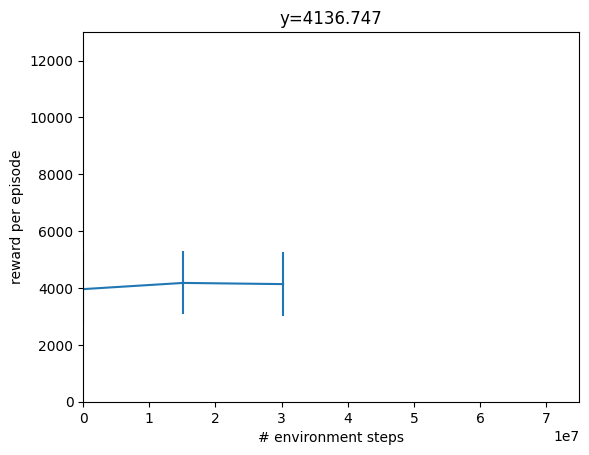

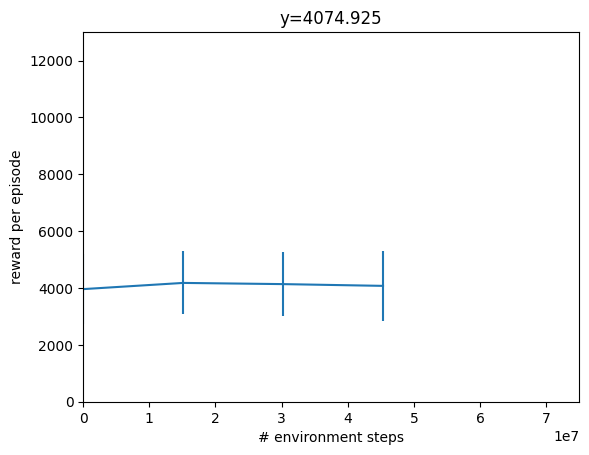

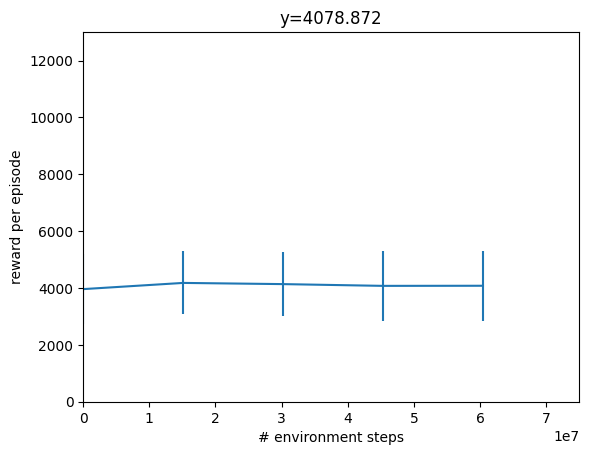

time to jit: 0:00:10.230747
time to train: 0:01:33.145090


In [61]:
train_fn = functools.partial(
    ppo.train, num_timesteps=60_000_000, num_evals=5, reward_scaling=0.1,
    episode_length=1000, normalize_observations=True, action_repeat=1,
    unroll_length=10, num_minibatches=24, num_updates_per_batch=8,
    discounting=0.97, learning_rate=3e-4, entropy_cost=1e-3, num_envs=3072,
    batch_size=512, seed=0)


x_data = []
y_data = []
ydataerr = []
times = [datetime.now()]

max_y, min_y = 13000, 0
def progress(num_steps, metrics):
  times.append(datetime.now())
  x_data.append(num_steps)
  y_data.append(metrics['eval/episode_reward'])
  ydataerr.append(metrics['eval/episode_reward_std'])

  plt.xlim([0, train_fn.keywords['num_timesteps'] * 1.25])
  plt.ylim([min_y, max_y])

  plt.xlabel('# environment steps')
  plt.ylabel('reward per episode')
  plt.title(f'y={y_data[-1]:.3f}')

  plt.errorbar(
      x_data, y_data, yerr=ydataerr)
  plt.show()

make_inference_fn, params, _= train_fn(environment=env, progress_fn=progress)

print(f'time to jit: {times[1] - times[0]}')
print(f'time to train: {times[-1] - times[1]}')

In [56]:
#@title Save Model
model_path = 'mjx_brax_policy'
model.save_params(model_path, params)

In [57]:
#@title Load Model and Define Inference Function
params = model.load_params(model_path)

inference_fn = make_inference_fn(params)
jit_inference_fn = jax.jit(inference_fn)

In [58]:
eval_env = envs.get_environment(env_name)

jit_reset = jax.jit(eval_env.reset)
jit_step = jax.jit(eval_env.step)

In [60]:
# initialize the state
rng = jax.random.PRNGKey(0)
state = jit_reset(rng)
rollout = [state.pipeline_state]

# grab a trajectory
n_steps = 1500
render_every = 2

for i in range(n_steps):
  act_rng, rng = jax.random.split(rng)
  ctrl, _ = jit_inference_fn(state.obs, act_rng)
  state = jit_step(state, ctrl)
  rollout.append(state.pipeline_state)

  if state.done:
    break

#media.show_video(env.render(rollout[::render_every], camera='side'), fps=1.0 / env.dt / render_every)
media.show_video(env.render(rollout[::render_every]), fps=1.0 / env.dt / render_every)